# Project Solution Lab 2: 

# Problem: Recommend Movies or Shows to Users

Modified from:
- [Implementing a Recommender System with SageMaker, MXNet, and Gluon](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb)
- [An Introduction to Factorization Machines with MNIST](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/factorization_machines_mnist/factorization_machines_mnist.ipynb)
- [Extending Amazon SageMaker Factorization Machines Algorithm to Predict Top X Recommendations](https://aws.amazon.com/blogs/machine-learning/extending-amazon-sagemaker-factorization-machines-algorithm-to-predict-top-x-recommendations/)

## Introduction to business scenario

You work for a startup that focuses on delivering on-demand video streaming services to users. The company wants to introduce movie/show recommendations for their users based on their viewing history.

You are tasked with solving part of this problem by leveraging machine learning to create a recommendation engine to be used on the user website. You are given access to the dataset of historical user preferences and the movies they watched. You can use this to train a machine learning model to recommend movies/shows to watch.

## About this dataset  
The Amazon Customer Reviews Dataset is a collection of reviews on different products from the Amazon.com marketplace from 1995 until 2015. Customer reviews are one of the most important data types at Amazon. Collecting and showing reviews has been part of the Amazon culture since the beginning of the company and is arguably one important source of innovation. For more details on this dataset, see [Amazon Customer Reviews Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

This exercise focuses on reviews of videos. The videos dataset contains 1- to 5-star ratings from over 2M Amazon customers on 160K digital videos.

### Features

**Data columns**

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written 

**Data format**
- Tab `\t` separated text file, without quote or escape characters
- First line in each file is header; 1 line corresponds to 1 record

### Dataset attributions

Website: https://s3.amazonaws.com/amazon-reviews-pds/readme.html

This dataset is being provided to you by permission of Amazon and is subject to the terms of the AWS Digital Training Service Agreement (available at https://aws.amazon.com/training/digital-training-agreement). You are expressly prohibited from copying, modifying, selling, exporting, or using this dataset in any way other than for the purpose of completing this lab.

## Brainstorming and designing a question...

...That you can answer with machine learning. 

The first step in most projects is to think about the question you want to ask, how the data available supports this question, and which tool (in this case, machine learning model) you are going to use to answer the question. This is an important step because it helps narrow the scope of exploration and gives clarity on the features that you are going to use. 

Take a moment to write your thoughts regarding the dataset in the cell below. What are the things you can predict with machine learning? Why may that be relevant from a business/client perspective? Explain why you consider these thoughts important.

In [ ]:
# Write your thoughts here

There might be several ideas about what to do with the data, but for now we are all going to work on recommending a video to a particular user.

## Recommendation and factorization machines

In many ways, recommender systems were a catalyst for the current popularity of machine learning. One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature. The million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and machine learning algorithms. Most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework. However, the core component is almost always a model that predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users. The minimal required dataset for this is a history of user item ratings (which we have).

The method that you'll use is a factorization machine. A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks. It is an extension of a linear model and is designed to parsimoniously (simply) capture interactions between features in high-dimensional sparse datasets. This makes it a good candidate to handle data patterns with features such as click prediction and item recommendation.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.
\# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.
\# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.
\# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.
\# Write your answer here


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

Start by specifying:
- The Amazon Simple Storage Service (Amazon S3) bucket and prefix(?) that you want to use for training and model data. This should be within the same Region as the Notebook Instance, training, and hosting.
- The AWS Identity and Access Management (IAM) role [Amazon Resource Name (ARN)](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) used to give training and hosting access to your data. See the documentation for how to create these.

**Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `get_execution_role()` call with the appropriate full IAM role ARN string(s).

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [1]:
# Change the bucket and prefix according to your information
#bucket = '<LabBucketName>'
bucket = 'ml-pipeline-bucket'
prefix = 'sagemaker-fm' 

import sagemaker
role = sagemaker.get_execution_role()

Now, load some Python libraries you'll need for the remainder of this example notebook.

In [2]:
import os, subprocess
import warnings
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Add this to display all the outputs in the cell and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [3]:
# Check whether the file is already in the desired path or if it needs to be downloaded

base_path = '/home/ec2-user/SageMaker/project/data/AmazonReviews'
file_path = '/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp', 's3://amazon-reviews-pds/tsv' + file_path, base_path])
else:
    print('File already downloaded!')

CompletedProcess(args=['mkdir', '-p', '/home/ec2-user/SageMaker/project/data/AmazonReviews'], returncode=0)

CompletedProcess(args=['aws', 's3', 'cp', 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', '/home/ec2-user/SageMaker/project/data/AmazonReviews'], returncode=0)

### Reading the dataset

Read the data into a Pandas dataframe so that you can know what you are dealing with.

**Note:** You'll set `error_bad_lines=False` when reading the file in, because there appear to be a very small number of records that would create a problem otherwise.

**Hint:** You can use the built-in Python `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)). You can use the file path directly with Pandas `read_csv` with `delimiter='\t'`.

For example: `pd.read_csv('filename.tar.gz', delimiter = '\t', error_bad_lines=False)`

In [4]:
df = pd.read_csv(base_path + file_path, 
                 delimiter='\t',
                 error_bad_lines=False)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


Print the first few rows of your dataset.

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [5]:
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31


Now what is the information contained in all the columns?

### Anatomy of the dataset

Get a little more comfortable with the data and see what features are at hand.

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written

### Analyzing and processing the dataset

#### Exploring the data

**Question:** How many rows and columns do you have in the dataset?

Check the size of the dataset.  

**Hint**: Use the `<dataframe>.shape` function to check the size of your dataframe

In [6]:
df.shape

(3998345, 15)

Answer: (3998345,15)

**Question:** Which columns contain null values, and how many null values do they contain?

Print a summary of the dataset.

**Hint**: Use `<dataframe>.info` function using the keyword arguments `null_counts = True`

In [7]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998345 entries, 0 to 3998344
Data columns (total 15 columns):
marketplace          3998345 non-null object
customer_id          3998345 non-null int64
review_id            3998345 non-null object
product_id           3998345 non-null object
product_parent       3998345 non-null int64
product_title        3998345 non-null object
product_category     3998345 non-null object
star_rating          3998345 non-null int64
helpful_votes        3998345 non-null int64
total_votes          3998345 non-null int64
vine                 3998345 non-null object
verified_purchase    3998345 non-null object
review_headline      3998320 non-null object
review_body          3998267 non-null object
review_date          3998207 non-null object
dtypes: int64(5), object(10)
memory usage: 457.6+ MB


**Answer:** Review headline: 25, Review_body: 78, Review_date: 138

**Question:** Are there any duplicate rows? If yes, how many are there?

**Hint**: Filter the dataframe using `dataframe.duplicated()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html#pandas.DataFrame.duplicated)) and check the length of the new dataframe.

In [8]:
duplicates = df[df.duplicated()]

len(duplicates)

0

**Answer:** There are no duplicated rows.

### Data preprocessing

Now it's time to decide what features you are going to use and how you are going to prepare them for your model. For this example, limit yourself to `customer_id`, `product_id`, `product_title`, and `star_rating`. Including additional features in the recommendation system could be beneficial but would require substantial processing (particularly the text data), which would be beyond the scope of this notebook.

Reduce this dataset and only use the columns mentioned.

**Hint:** Select multiple columns as a dataframe by passing the columns as a list. For example: `df[['column_name 1', 'column_name 2']]`

In [9]:
df_reduced = df[['customer_id', 'product_id', 'star_rating', 'product_title']]

Check if you have duplicates after reducing the dataset. 

In [10]:
duplicates = df_reduced[df_reduced.duplicated()]

len(duplicates)

131

**Answer**: 131

**Question:** Why do you have duplicates in your dataset now? What changed after you reduced the dataset? Review the first 20 lines of the duplicates.

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [11]:
duplicates.head(20)

,customer_id,product_id,star_rating,product_title
565194,41454255,B00Y2UYRFS,1,unseen 2
594322,17570065,B00R3EEO2G,2,The Maze Runner
611264,15703996,B00I3MQNWG,5,Bosch Season 1
612471,28456429,B008Y6W7J4,5,Rabbit Hole
613791,52388381,B00YORA25I,5,"McFarland, USA (Theatrical)"
685156,31828958,B00TT53YSW,5,"Bates Motel, Season 3"
1204110,19462,B00QWUL4AW,5,Exodus: Gods and Kings
1564816,24892653,B00L2GPYKW,5,The Escape Artist Season 1
1601662,44513234,B00NY4UIKG,5,The Equalizer
1616429,43345475,B00P5968FC,3,The Babadook


**Hint:** Take a look at the first two elements in the duplicates dataframe, and query the original dataframe df to see what the data looks like. You can use the `query` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html)).

For example:

```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [
        })
df_eg.query('A > 1 & B > 0')
```

In [12]:
df.query("customer_id == 17570065 & product_id == 'B00R3EEO2G'")

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
588857,US,17570065,RZ0MXSMTR2WQP,B00R3EEO2G,226574237,The Maze Runner,Digital_Video_Download,2,0,0,N,Y,Two Stars,Simply doesn't engage the audience.,2015-06-08
594322,US,17570065,R26IBV6N1BV1VN,B00R3EEO2G,226574237,The Maze Runner,Digital_Video_Download,2,0,0,N,Y,Two Stars,Simply doesn't engage the audience.,2015-06-08


**Answer:** The dataset has duplicates because there are products with the same information but different `review_id` or `product_id`.

Before continuing, remove the duplicate rows.

**Hint**: Use the `~` operator to select all the rows that aren't duplicated. For example:
    
```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [2,0,5,2]
        })
df_eg[~(df_eg['B'] > 0)]
```

In [ ]:
df_reduced = df_reduced[~df_reduced.duplicated()]

### Visualize some of the rows in the dataset
If you haven't done so in the above, you can use the space below to further visualize some of your data. Look specifically at the distribution of features like `star_rating`, `customer_id`, and `product_id`.

**Specific questions to consider**

1. After looking at the distributions of features, to what extent might those features help your model? Is there anything you can deduce from those distributions that might be helpful in better understanding your data? 

2. Should you use all the data? What features should you use?

3. What month has the highest count of user ratings?

Use the cells below to visualize your data and answer these and other questions that might be of interest to you. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and similar questions in your project presentations.</span>

Use `sns.barplot` ([documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html)) to plot the `star_rating` density and distribution.

,index,star_rating
0,5,2410533
1,4,756423
2,3,345891
3,1,289731
4,2,195767


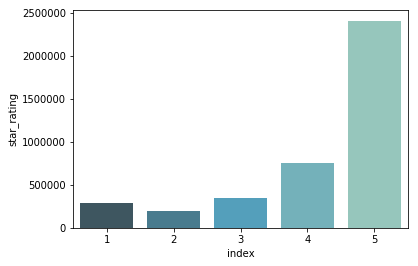

In [13]:
# Count the number of reviews with a specific rating
df['star_rating'].value_counts().reset_index()
sns.barplot(
    x='index', 
    y='star_rating', 
    data=_,  # The underscore symbol in Python is used to store the output of the last operation
    palette='GnBu_d'
)

**Question:** What month contains the highest count of user ratings?

**Hint**:  
1. Use `pd.to_datetime` to convert the `review_date` column to a datetime column.  
2. Use the month from the `review_date` column. You can access it for a datetime column using `<column_name>.dt.month`.
3. Use the `groupby` function using `idxmax`.


,review_date,star_rating
0,1.0,309083
1,2.0,369059
2,3.0,432084
3,4.0,363611
4,5.0,339285
5,6.0,328114
6,7.0,417844
7,8.0,464912
8,9.0,206453
9,10.0,218583


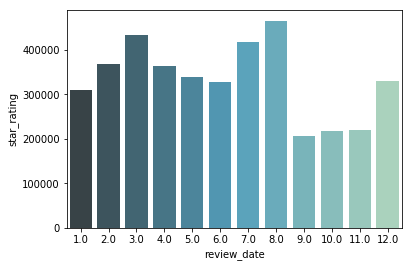

In [14]:
# Convert the review date to a datetime type and count the number of ratings by month
df['review_date'] = pd.to_datetime(df.review_date)
df.groupby(df.review_date.dt.month).star_rating.count().reset_index()
sns.barplot(x='review_date', y='star_rating', data=_, palette='GnBu_d')

In [15]:
max_month = df.groupby(df.review_date.dt.month).star_rating.count().idxmax()
print(f'The month with the most reviews is: {max_month}')

The month with the most reviews is: 8.0


**Bonus question (optional):** Which years have the most and least reviews?

,review_date,star_rating
0,2000.0,1
1,2001.0,1
2,2002.0,5
3,2003.0,4
4,2004.0,6
5,2005.0,11
6,2006.0,185
7,2007.0,2597
8,2008.0,3079
9,2009.0,3262


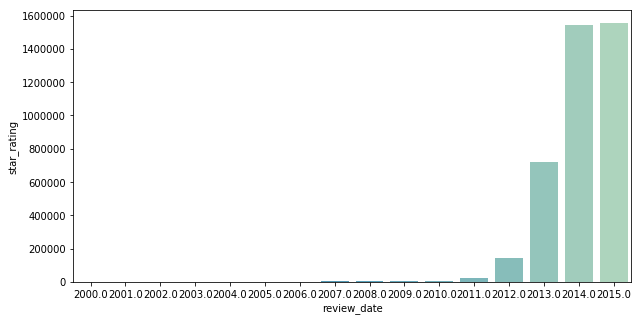

In [16]:
df.groupby(df.review_date.dt.year).star_rating.count().reset_index()
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.barplot(x='review_date', y='star_rating', data=_, palette='GnBu_d')

**Answer:** The years with the least amount of data are 2000 and 2001, with only 1 review. The year with the highest number of reviews is 2015.

### Cleaning data

**Question**: How heterogeneous are the number of reviews per customer and reviews per video? Use quantiles to find out.

**Hint**: Use `<dataframe>['columns_name'].value_counts()` for the customers and products dataframe, and use `<dataframe>.quantile(<list>)` to find the relationship.

In [17]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 
             0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 
             0.999, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.000       1.0
0.010       1.0
0.020       1.0
0.030       1.0
0.040       1.0
0.050       1.0
0.100       1.0
0.250       1.0
0.500       1.0
0.750       2.0
0.900       4.0
0.950       5.0
0.960       6.0
0.970       7.0
0.980       9.0
0.990      13.0
0.995      18.0
0.999      37.0
1.000    2704.0
Name: customer_id, dtype: float64
products
 0.000        1.000
0.010        1.000
0.020        1.000
0.030        1.000
0.040        1.000
0.050        1.000
0.100        1.000
0.250        1.000
0.500        3.000
0.750        9.000
0.900       31.000
0.950       73.000
0.960       95.000
0.970      130.000
0.980      199.000
0.990      386.670
0.995      699.000
0.999     1993.901
1.000    32790.000
Name: product_id, dtype: float64


**Answer:** Only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

Filter out this long tail. Select the customers that have rated 18 or more videos and the products that have more than 95 reviews.

In [18]:
customers1 = customers[customers >= 18]
products1 = products[products >= 95]

reduced_df = (
    df_reduced.merge(pd.DataFrame({'customer_id': customers1.index}))
              .merge(pd.DataFrame({'product_id': products1.index}))
)

**Question:** What is the shape of `customers1`, `products1`, and the new dataframe reduced_df?

**Note**: Use f-strings for this:

```
x= 3
print(f'X = {x}')
```

In [19]:
print(f'Number of users is {customers1.shape[0]} and number of items is {products1.shape[0]}.')
print(f'Length of reduced df is {reduced_df.shape[0]}.')

Number of users is 10538 and number of items is 6683.
Length of reduced df is 173506.


Print the first 5 columns of the dataframe.

In [20]:
reduced_df.head()

,customer_id,product_id,star_rating,product_title
0,11763902,B00PSLQYWE,4,Downton Abbey Season 5
1,1411480,B00PSLQYWE,5,Downton Abbey Season 5
2,35303629,B00PSLQYWE,5,Downton Abbey Season 5
3,21285980,B00PSLQYWE,5,Downton Abbey Season 5
4,29260449,B00PSLQYWE,5,Downton Abbey Season 5


**Question:** Does `reduced_df` maintain the same ratio of ratings?

,index,star_rating
0,5,86202
1,4,42669
2,3,24471
3,2,10803
4,1,9361


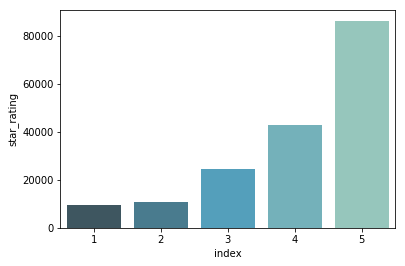

In [21]:
reduced_df['star_rating'].value_counts().reset_index()
sns.barplot(x='index', y='star_rating', data=_, palette='GnBu_d')

**Answer:** The number of reviews with a 1-star rating decreased in proportion to 2-star ratings. That was not the case with the original data.

Now, recreate the customer and product distributions of count per customer and product.  

**Hint**: Use the `value_counts()` function on the `customer_id` and `product_id` columns.

Text(0.5, 0.98, 'Distribution of counts per customer and product')

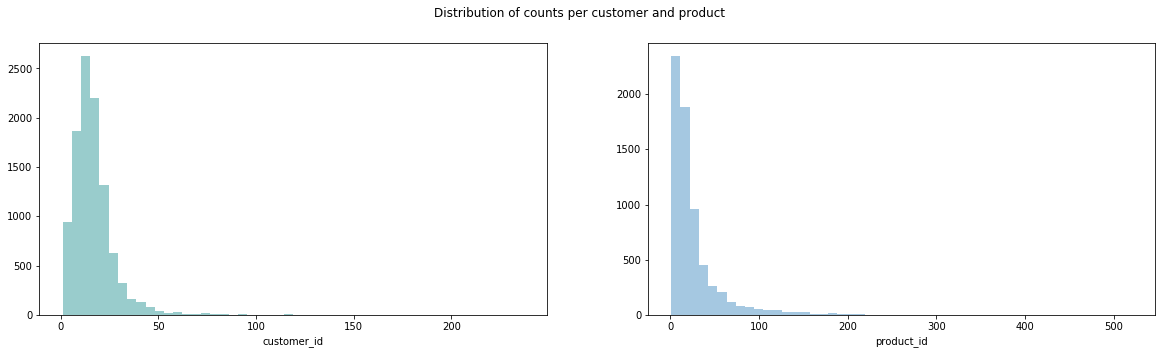

In [22]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Distribution of counts per customer and product')
sns.distplot(customers, kde=False, ax=axs[0], color='teal')
sns.distplot(products, kde=False, ax=axs[1])

Next, number each user and item, giving them their own sequential index. This will allow you to hold the information in a sparse format where the sequential indices indicate the row and column in the ratings matrix.

To create the `customer_index` and `product_index`, create a new dataframe with `customer_id` as the index value and a sequential counter/values for the user and item number. Once you are finished creating both indexes, use the Pandas `merge` function to merge `customer_index` with `product_index`.

**Hint**: Use the `shape` function to generate the total number of customers and products. Use `np.arange` to generate a list of numbers from 0 to the number of customers and products.

In [23]:
customer_index = pd.DataFrame({'customer_id': customers.index, 
                               'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,11763902,B00PSLQYWE,4,Downton Abbey Season 5,3065,103
1,1411480,B00PSLQYWE,5,Downton Abbey Season 5,130,103
2,35303629,B00PSLQYWE,5,Downton Abbey Season 5,4683,103
3,21285980,B00PSLQYWE,5,Downton Abbey Season 5,449,103
4,29260449,B00PSLQYWE,5,Downton Abbey Season 5,131,103


Sample answer:
<div class="output_subarea"><div>

<table class="dataframe" border="1">
  <thead>
    <tr style="text-align: right">
      <th></th>
      <th>customer_id</th>
      <th>product_id</th>
      <th>star_rating</th>
      <th>product_title</th>
      <th>user</th>
      <th>item</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>11763902</td>
      <td>B00PSLQYWE</td>
      <td>4</td>
      <td>Downton Abbey Season 5</td>
      <td>3065</td>
      <td>103</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1411480</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>130</td>
      <td>103</td>
    </tr>
    <tr>
      <th>2</th>
      <td>35303629</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>4683</td>
      <td>103</td>
    </tr>
    <tr>
      <th>3</th>
      <td>21285980</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>449</td>
      <td>103</td>
    </tr>
    <tr>
      <th>4</th>
      <td>29260449</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>131</td>
      <td>103</td>
    </tr>
  </tbody>
</table>
</div></div>

# Project Solution Lab 3: 

# Step 3: Model training and evaluation

There are some preliminary steps that you must include when converting the dataset from a dataframe to a format that a machine learning algorithm can use. For Amazon SageMaker, here are the steps you need to take:

1. Split the data into `train_data` and `test_data`.    
2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html). For this problem, the data will be sparse, so you can use the `scipy.sparse.lilmatrix` function and then convert the function to the `RecordIO protobuf` format using `sagemaker.amazon.common.write_spmatrix_to_sparse_tensor`.    
3. Upload the data to your Amazon S3 bucket. If you have not created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).    

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Take note of the key decisions you've made in this phase in your project presentations.</span>

### Prepare the data

You are at a point where you can start preparing the dataset as input for your model. Every model has different input needs. Some of the algorithms implemented in Amazon SageMaker require the data to be in the recordIO-wrapped protobuf form. You will take care of that in the following cells.

First, split the dataset into training and test sets. This will allow you to estimate the model's accuracy on videos that customers rated but that weren't included in the training.

Start with creation of the `test_df` dataframe. Create the dataframe by grouping the dataframe on `customer_id` and using the `last` function, similar to `pd.groupby('  ').last()`.

In [24]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

To create the training data, remove the values present in `test_df` from the `reduced_df` dataframe.

**Hint**: Merge the `reduced_df` dataframe with the `test_df` dataset with `customer_id` and `product_id` columns as an outer join.

In [25]:
train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')].reset_index()

In [26]:
test_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,10981,B00D6BQG1W,5,Warm Bodies,1859,3673
1,12783,B001GQK56G,4,Inspector Morse Season 1,1951,2794
2,17106,B00RPNBLWG,5,A Most Violent Year,10337,2057
3,19462,B00DFFI7K2,1,G.I. Joe: Retaliation,8674,624
4,54160,B005OPTSIQ,2,Workaholics Season 2,7309,3794


Now you can look at some basic characteristics of the data that will later help you convert the features to an appropriate format for training your model.

Create two variables `nb_rating_test` and `nb_ratings_train` for the length of the test and training datasets.

In [27]:
nb_ratings_test = len(test_df.index)
nb_ratings_train = len(train_df.index)
print(f" Training Count: {nb_ratings_train}")
print(f" Test Count: {nb_ratings_test}")

 Training Count:  163069
 Test Count:  10436


### Data conversion

Now, you can convert your Pandas dataframes into a sparse matrix. This process is the same for both train and test. The Amazon SageMaker implementation of factorization machines takes recordIO-wrapped protobuf, where the data you have today is a Pandas dataframe on disk. Therefore, you are going to convert the data to a sparse matrix to express the relationships between each user and each movie.

In [28]:
# First convert data to sparse fomat with scipy lil_matrix

from scipy.sparse import lil_matrix

def loadDataset(df, lines, columns, regressor=True):
    """
    Convert the pandas dataframe into sparse matrix
    
    Args:
        df: DataFrame
        lines: number of rows of the final sparse matrix
        columns: number of columns of final sparse matrix
        regressor: Boolean value to check if we are using regression
                  or classification
    Returns:
        X: Feature vector
        Y: Label vector
    """
    # Features are one-hot encoded in a sparse matrix
    # Use scipy.sparse.lil_matrix to create the feature vector X of type float32
    X = lil_matrix((len(df), lines + columns)).astype('float32')
    
    # Labels are stored in a vector. Instantiate an empty label vector Y.
    Y = []
    
    line = 0
    
    # For each row in the dataframe, use 1 for the item and product number
    for index, row in df.iterrows():
        X[line,row['user']] = 1
        X[line, lines + (row['item'])] = 1
        line += 1

        if regressor:
            # If using regression, append the star_rating
            Y.append(row['star_rating'])
        else:
            # Use 1 for star_rating 5 else use 0
            if int(row['star_rating']) >= 5:
                Y.append(1)
            else:
                Y.append(0)
    
    # Convert the list into NumPy array of type float32  
    Y = np.array(Y).astype('float32')
    return X, Y

Use the `loadDataset` function to create the training and test sets.

In [29]:
print(customers.shape[0], 
      products.shape[0],
      customers.shape[0] + products.shape[0])

X_train, Y_train = loadDataset(train_df, customers.shape[0], 
                               products.shape[0])
X_test, Y_test = loadDataset(test_df, customers.shape[0], 
                             products.shape[0])

10436 6659 17095


Now that your data is in a sparse format, save it as a protobuf format and upload it to Amazon S3. This step might look intimidating, but most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as SageMaker below.

In [30]:
import io 
import sagemaker.amazon.common as smac

def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
fm_train_data_path = writeDatasetToProtobuf(X_train, bucket, prefix, 'train', "sparse", Y_train)    
fm_test_data_path  = writeDatasetToProtobuf(X_test, bucket, prefix, 'test', "sparse", Y_test)    
  
print("Training data S3 path: ", fm_train_data_path)
print("Test data S3 path: ", fm_test_data_path)

Training data S3 path:  s3://ml-pipeline-010220085057-us-west-2-qls-150426-bf758deefff18ef6/sagemaker-fm/train
Test data S3 path:  s3://ml-pipeline-010220085057-us-west-2-qls-150426-bf758deefff18ef6/sagemaker-fm/test


You are finally finished with data preparation. Hooray! As you can see, it takes a lot of time and effort to clean and prepare the data for modeling. This is true for every single data science project, and this step has a high impact on the outcome. Make sure you spend enough time understanding and preparing your data for training in all future machine learning dventures!

## Training the model

Now it's time to train the model. You will use an Amazon SageMaker training job for that. Amazon SageMaker training jobs are an easy way to create models, as you don't really have to write all the code for training. That is already handled for you in a nice container format.

The general workflow for creating training jobs from the notebook is to instantiate the predictor, pass some hyperparameters, and then pass the data in the correct format. This is what happens in the following cell.

For more more information about FM estimator, see [FactorizationMachines](https://sagemaker.readthedocs.io/en/stable/factorization_machines.html).

For more information about hyperparameters, see [Factorization Machines Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html).

**Hint**: Example:

```
sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)
                                    
pca.set_hyperparameters(featuer_dim=50000,
                        num_components=10,
                        subtract_mean=True,
                        algorithm_mode='randomized',
                        mini_batch_size=200)
                        
pca.fit({'train': s3_train_data})
```

In [31]:
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

output_prefix = 's3://' + bucket + '/sagemaker-fm/model'
instance_type='ml.m4.xlarge'
batch_size = 128

fm = sagemaker.estimator.Estimator(
    get_image_uri(boto3.Session().region_name, "factorization-machines"),
    role, 
    train_instance_count=1, 
    train_instance_type=instance_type,
    output_path=output_prefix,
    sagemaker_session=sagemaker.Session()
)

fm.set_hyperparameters(feature_dim=X_train.shape[1],
                       predictor_type='regressor',
                     # predictor_type='binary_classifier',
                       mini_batch_size=batch_size,
                       num_factors=64,
                       epochs=25,
                       clip_gradient=5.0,
                       rescale_grad=1.0/batch_size)

fm.fit({'train': fm_train_data_path, 'test': fm_test_data_path})

2020-01-29 21:31:46 Starting - Starting the training job...
2020-01-29 21:31:47 Starting - Launching requested ML instances...
2020-01-29 21:32:45 Starting - Preparing the instances for training.........
2020-01-29 21:34:12 Downloading - Downloading input data...
2020-01-29 21:34:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[01/29/2020 21:34:47 INFO 139767193593664] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'norm

[01/29/2020 21:34:55 INFO 139767193593664] Iter[2] Batch [500]#011Speed: 53904.64 samples/sec
[01/29/2020 21:34:55 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=500 train rmse <loss>=1.09045468208
[01/29/2020 21:34:55 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=500 train mse <loss>=1.18909141368
[01/29/2020 21:34:55 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=500 train absolute_loss <loss>=0.867777257741
[01/29/2020 21:34:56 INFO 139767193593664] Iter[2] Batch [1000]#011Speed: 55645.11 samples/sec
[01/29/2020 21:34:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=1000 train rmse <loss>=1.11662823249
[01/29/2020 21:34:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=1000 train mse <loss>=1.2468586096
[01/29/2020 21:34:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=2, batch=1000 train absolute_loss <loss>=0.892877708782
[2020-01-29 21:34:57.025] [tensorio] [info] epo

[01/29/2020 21:35:05 INFO 139767193593664] Iter[5] Batch [1000]#011Speed: 52467.40 samples/sec
[01/29/2020 21:35:05 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, batch=1000 train rmse <loss>=1.07639845246
[01/29/2020 21:35:05 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, batch=1000 train mse <loss>=1.15863362845
[01/29/2020 21:35:05 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, batch=1000 train absolute_loss <loss>=0.857358045184
[2020-01-29 21:35:06.095] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 12, "duration": 3034, "num_examples": 1274, "num_bytes": 10436416}
[01/29/2020 21:35:06 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, train rmse <loss>=1.08825031892
[01/29/2020 21:35:06 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, train mse <loss>=1.18428875663
[01/29/2020 21:35:06 INFO 139767193593664] #quality_metric: host=algo-1, epoch=5, train absolute_loss <loss>=0.86980

[01/29/2020 21:35:16 INFO 139767193593664] Iter[9] Batch [500]#011Speed: 54226.62 samples/sec
[01/29/2020 21:35:16 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=500 train rmse <loss>=1.01463779098
[01/29/2020 21:35:16 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=500 train mse <loss>=1.02948984688
[01/29/2020 21:35:16 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=500 train absolute_loss <loss>=0.797497733208
[01/29/2020 21:35:17 INFO 139767193593664] Iter[9] Batch [1000]#011Speed: 54668.57 samples/sec
[01/29/2020 21:35:17 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=1000 train rmse <loss>=1.04104809143
[01/29/2020 21:35:17 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=1000 train mse <loss>=1.08378112867
[01/29/2020 21:35:17 INFO 139767193593664] #quality_metric: host=algo-1, epoch=9, batch=1000 train absolute_loss <loss>=0.825475757802
[2020-01-29 21:35:18.053] [tensorio] [info] ep

[01/29/2020 21:35:26 INFO 139767193593664] Iter[12] Batch [1000]#011Speed: 53437.85 samples/sec
[01/29/2020 21:35:26 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, batch=1000 train rmse <loss>=1.02105531636
[01/29/2020 21:35:26 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, batch=1000 train mse <loss>=1.04255395907
[01/29/2020 21:35:26 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, batch=1000 train absolute_loss <loss>=0.806938247545
[2020-01-29 21:35:27.043] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 26, "duration": 2990, "num_examples": 1274, "num_bytes": 10436416}
[01/29/2020 21:35:27 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, train rmse <loss>=1.03314536748
[01/29/2020 21:35:27 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, train mse <loss>=1.06738935034
[01/29/2020 21:35:27 INFO 139767193593664] #quality_metric: host=algo-1, epoch=12, train absolute_loss <loss>=

[2020-01-29 21:35:35.904] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 32, "duration": 2959, "num_examples": 1274, "num_bytes": 10436416}
[01/29/2020 21:35:35 INFO 139767193593664] #quality_metric: host=algo-1, epoch=15, train rmse <loss>=1.0163415585
[01/29/2020 21:35:35 INFO 139767193593664] #quality_metric: host=algo-1, epoch=15, train mse <loss>=1.03295016354
[01/29/2020 21:35:35 INFO 139767193593664] #quality_metric: host=algo-1, epoch=15, train absolute_loss <loss>=0.803936834987
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2961.7550373077393, "sum": 2961.7550373077393, "min": 2961.7550373077393}}, "EndTime": 1580333735.90539, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1580333732.94247}

[01/29/2020 21:35:35 INFO 139767193593664] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1

[01/29/2020 21:35:45 INFO 139767193593664] Iter[19] Batch [500]#011Speed: 54835.56 samples/sec
[01/29/2020 21:35:45 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=500 train rmse <loss>=0.959414490797
[01/29/2020 21:35:45 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=500 train mse <loss>=0.920476165152
[01/29/2020 21:35:45 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=500 train absolute_loss <loss>=0.744607951946
[01/29/2020 21:35:47 INFO 139767193593664] Iter[19] Batch [1000]#011Speed: 55638.77 samples/sec
[01/29/2020 21:35:47 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=1000 train rmse <loss>=0.985380732217
[01/29/2020 21:35:47 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=1000 train mse <loss>=0.970975187424
[01/29/2020 21:35:47 INFO 139767193593664] #quality_metric: host=algo-1, epoch=19, batch=1000 train absolute_loss <loss>=0.77286731908
[2020-01-29 21:35:47.773] [tensorio

[01/29/2020 21:35:56 INFO 139767193593664] Iter[22] Batch [1000]#011Speed: 54239.86 samples/sec
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, batch=1000 train rmse <loss>=0.97295456747
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, batch=1000 train mse <loss>=0.94664059036
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, batch=1000 train absolute_loss <loss>=0.760813476739
[2020-01-29 21:35:56.714] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 46, "duration": 2976, "num_examples": 1274, "num_bytes": 10436416}
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, train rmse <loss>=0.984633375638
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, train mse <loss>=0.969502884421
[01/29/2020 21:35:56 INFO 139767193593664] #quality_metric: host=algo-1, epoch=22, train absolute_loss <loss


2020-01-29 21:36:13 Uploading - Uploading generated training model
2020-01-29 21:36:13 Completed - Training job completed
Training seconds: 121
Billable seconds: 121


**Question:** What does changing the `batch_size` and `epochs` do to the final metric?  

**Answer:** There are a couple of things to notice here. The `predictor_type` is set to `'regressor'` because you are trying to predict the star rating. The `batch_size` is set to 128. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases. `num_factors` is set to 64. As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious (simple) model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher dimensional representation of feature interactions but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.

**Question:** Check the output of the model. What is the meaning of the metrics used? Is there a difference between the training and testing sets? If yes, what is the meaning of that?  

**Answer:** The **MSE**, **RMSE**, and **Absolute loss** are considerably lower in the training set than in the testing dataset. This might indicate that the model is being molded to the pattern of the training set and not the general pattern on the reviews. This phenomenon is called overfitting.

### Evaluate

Congratulations! You have successfully launched an Amazon SageMaker training job. Now what? Well, you need a way to verify that your model is actually predicting coherent values. How do you do this?

Start by calculating a naive baseline to approximate how well your model is doing. The simplest estimate would be to assume every user item rating is just the average rating over all ratings. This is basically saying that you have a model that only learned to output the mean value of all reviews.

**Note:** You could do better by using each individual video's average; however, in this case, it doesn't really matter because the same conclusions would hold.

Calculate the mean of `star_rating` to get the `naive_guess`. Then, calculate the naive MSE by squaring the naive guess from the test `star_rating` and getting an average.

$average(test(star\_rating) - naive\_guess)^2)$

In [32]:
naive_guess = np.mean(train_df['star_rating'])
print('Naive MSE:', np.mean((test_df['star_rating'] - naive_guess) ** 2))

Naive MSE: 1.501868207928254


Now, calculate predictions for your test dataset. To this end, you'll need to _deploy_ the model you just trained.

**Note:** This will align closely to your CloudWatch output above but may differ slightly due to skipping partial mini-batches in the `eval_net` function.

Use `<estimator_name>.deploy` with `initial_instance_count=1, instance_type=ml.m4.xlarge`.

In [33]:
fm_predictor = fm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

Now that your endpoint is 'InService', evaluate how your model performs on the test set. Compare that test set performance to the performance on the training set. 

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record questions to these and other similar questions you might answer in this section in your project presentations. Record key details and decisions you've made in your project presentations.</span>

The deployment process involves creating an instance of the specified size, in this case `ml.m4.xlarge`, with the model you trained and saved on Amazon S3. To get a prediction, you need to pass your data in a serialized form of JSON. The output you get from the inference will be in serialized JSON form as well, so you also need to deserialize it to get the predicted values.

In [34]:
# Create a serializer function for the predictor
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

Check how your training set did. Use the endpoint to get predictions from your model.

First, look at what a single prediction looks like.

Amazon SageMaker model containers must respond to requests within 60 seconds. The model itself can have a maximum processing time of 60 seconds before responding to the /invocations. To do that, call the `predict` function for 5 rows at a time and then add those rows to a list. 

In [35]:
# Pass the X_train data to the predictor deployed 
ytrain_p = []
for i in range(0, 1000, 5):
    preds = fm_predictor.predict(X_train[i:i + 5].toarray())['predictions']
    p = [ytrain_p.append(x['score']) for x in preds]

**Question:** Now that you have inferences, do a sanity check. What are the minimum and maximum values predicted in the inferences? Do those correspond to the minimum and maximum values in the training data?

In [36]:
print('The minimum rating predicted is: ', min(ytrain_p), 'and the maximum is: ',max(ytrain_p))

The minimum rating predicted is:  3.165067195892334 and the maximum is:  4.865056037902832


Now, check your test dataset.

In [37]:
Y_pred = []
for i in range(0, X_test.shape[0], 5):
    preds = fm_predictor.predict(X_test[i:i+5].toarray())['predictions']
    p = [Y_pred.append(x['score']) for x in preds]

**Question:** How are the min and max values alike in the predictions? Bonus point if you check the entire distribution (histogram).

In [38]:
max(Y_pred), min(Y_pred)

(5.0329670906066895, 2.6423165798187256)

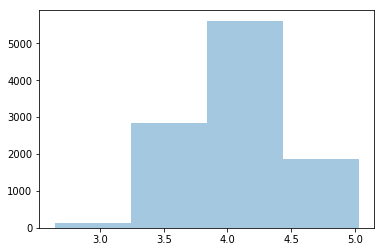

In [39]:
sns.distplot(Y_pred, kde=False, bins=4)

Finally, calculate the mean squared error for the test set and see how much of an improvement it is from the baseline.

In [40]:
print('MSE:', np.mean((test_df['star_rating'] - Y_pred) ** 2))

MSE: 1.242589756902862


For recommender systems, subjective accuracy also matters. Get some recommendations for a random user to see if they make intuitive sense.

Try using user number 200, and see what they have watched and rated highly.

In [41]:
reduced_df[reduced_df['user'] == 200].sort_values(
    ['star_rating', 'item'], ascending=[False, True])

,customer_id,product_id,star_rating,product_title,user,item
60487,43080952,B00DTOYJJ2,5,Breaking Bad The Final Season,200,76
14249,43080952,B00VFTA70I,5,The Imitation Game,200,88
28407,43080952,B00KG2NGPS,5,The Monuments Men,200,152
71980,43080952,B00TPJHW7Q,5,The Theory of Everything,200,155
6753,43080952,B00IIVJU3Q,5,Philomena,200,180
84422,43080952,B0047WJ12K,5,Inception,200,473
161389,43080952,B00DGNO3WE,5,Quartet,200,1113
119444,43080952,B0059R5Q08,5,Jane Eyre,200,2711
167600,43080952,B001VLKWUA,5,Out of Africa,200,3064
136601,43080952,B00TF87WQI,5,Rosewater,200,3487


As you can see, this user likes to watch comedies, romance, and light-hearted movies and dislikes drama and fantasy movies. Let's see how your model predicts movie ratings for this user.

In [42]:
def prepare_predictions(user_id, number_movies, columns):
    # Create the sparse matrix 
    X = lil_matrix((number_movies, columns)).astype('float32')
    movie_index_start = columns - number_movies

    # Fill out the matrix. Each row will be the same user with every possible movie.
    for row in range(number_movies):
        X[row, user_id - 1] = 1
        X[row, movie_index_start + row] = 1

    return X

user_200 = prepare_predictions(200, products.shape[0], customers.shape[0] + products.shape[0])

Now create a list of all the ratings that the model would predict for user 200 for all movies.

In [43]:
pred_200 = []
for i in range(0, user_200.shape[0], 5):
    preds = fm_predictor.predict(user_200[i:i+5].toarray())['predictions']
    p = [pred_200.append(x['score']) for x in preds]

Now loop through and predict user 200's ratings for every common video in the catalog to see which ones to recommend or not recommend. 

Create a new dataframe `titles` by using the `reduced_df` dataframe to group by the items. Use the `product_title` column and create another column `score` and add the values from `pred_200` to it.

In [44]:
titles = reduced_df.groupby('item')['product_title'].first().reset_index()
titles['score'] = pred_200

**Question:** What products got the highest score?  

**Hint**: Use the `sort_values` function to sort columns `score` and `item` and use parameter `asecnding=[False,True]`

In [45]:
titles.sort_values(['score', 'item'], ascending=[False, True])

,item,product_title,score
25,25,John Adams Season 1,4.073676
5,5,Downton Abbey Season 3,4.051294
12,12,Justified Season 3,4.029004
6,6,Justified Season 4,4.009936
4,4,Justified Season 2,4.007755
47,47,Captain Phillips,4.000636
419,419,The Americans Season 2,3.997695
290,290,The Impossible,3.995503
2800,2800,The Wrecking Crew,3.992625
19,19,Band of Brothers Season 1,3.991545


**Question:** What can you conclude from the highly rated and lowest rated shows for the user?

**Answer:** The predicted highly rated shows have some well-reviewed TV dramas and some book adaptations. The lowest scores are from comedies, child, and teenage movies.  

See if your recommendations have correlations with other users. Try user 201. Perform the same operations as you did for user 200.

In [48]:
user_201 = prepare_predictions(201, products.shape[0], customers.shape[0] + products.shape[0])

pred_201 = []
for i in range(0, user_201.shape[0], 5):
    preds = fm_predictor.predict(user_201[i:i+5].toarray())['predictions']
    p = [pred_201.append(x['score']) for x in preds]

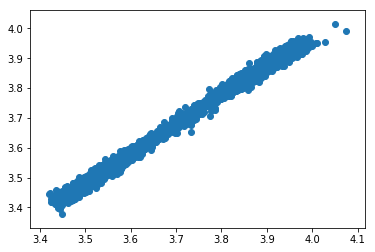

In [49]:
plt.scatter(pred_200, pred_201)
plt.show()

**Question:** What can you conclude from the scatter plot between the two users?  

**Answer:** This correlation is nearly perfect. Essentially, the average rating of items dominates across users, and our system will recommend the same well-reviewed items to everyone. That basically means that the model is only finding the best rated shows and presenting them to all users. Now we need to see if we can do better by shifting the paradigm from regression to classification.

Delete the endpoint you created for inference because you won't be using it anymore.

In [50]:
sagemaker.Session().delete_endpoint(fm_predictor.endpoint)